In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pprint import pprint
import configparser
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, f1_score, average_precision_score, confusion_matrix
from IPython.display import display, SVG
sys.path.append(os.path.abspath(os.path.join(os.pardir, 'utils')))
import preprocessing
import visualize

config = configparser.ConfigParser()
config.read(os.path.join(os.pardir, 'config.ini'))

vg_json = config['PATHS']['vg-json']
data_dir = config['PATHS']['data']
image_dir = config['PATHS']['vg-images']
input_dir = data_dir+'prediction_arrays/'

colors = preprocessing.basic_colors()
classifier_list = 'pixelwise bottomup topdown latefusion earlyfusion'.split()


set_type = 'test'

greyscale = lambda x: plt.cm.gray(np.linspace(0.2,0.8,len(x)))

In [2]:
# util functions

def get_score(metric,classifier,df):
    ytrue = np.argmax(np.array(pd.get_dummies(df.color)), axis=1)
    ypred = np.argmax(np.array(eval(classifier+'_predict_df').loc[df.index]), axis=1)
    if metric == 'acc':
        return accuracy_score(ytrue,ypred)
    elif metric == 'f1':
        return f1_score(ytrue,ypred,average='macro')
    else :
        raise Exception('invalid metric')
        return None
    
def is_canonical(obj,color,cdo_map):
    if color == cdo_map[obj]:
        return True
    return False

def print_samples(df):
    for index, row in df.iterrows():
        visualize.plot_vg_image(row,image_dir)
        print(index)

def save_image(
    row, img_dir, out_dir, save=False, display=True, 
    print_pred=False, figure_size=(10,10), filename=None, 
    classifier_list=[], classifier_names=None, text='right'
        ):
    box_color = 'red'
    src_filename = str(row.image_id)+'.jpg'
    input_file = img_dir + src_filename
    image = cv2.imread(input_file)
    if not filename:
        filename = src_filename
    if not classifier_names:
        classifier_names = classifier_list

    bb ={
        'h' : row.bb_h,
        'w' : row.bb_w,
        'x' : row.bb_x,
        'y' : row.bb_y,
        'label' : row.color+' '+row.object_name
    }

    fig,ax = plt.subplots(figsize=figure_size)
    ax.imshow(np.flip(image,axis=2))
    if text == 'right':
        plt.text(bb['x']+bb['w']+10, bb['y']+bb['h']+10,bb['label'],fontsize=24,color='red',bbox=dict(facecolor='white'))
    elif text == 'left':
        plt.text(bb['x']-140, bb['y']+bb['h']-10,bb['label'],fontsize=24,color='red',bbox=dict(facecolor='white'))
    plt.axis('off')
    
    rect = patches.Rectangle((bb['x'],bb['y']),bb['w'],bb['h'],linewidth=7,edgecolor=box_color,facecolor=box_color,alpha=1,fill=False)
    ax.add_patch(rect)
    
    # LaTeX
    out_series = pd.Series()
    for classifier,name in list(zip(classifier_list, classifier_names)):
        out_series[name] = row[classifier+'_color']
    latex_out = out_series.to_latex(escape=False,header=False)
    for string in ['\n\\toprule', '\n\\bottomrule']:
        latex_out = latex_out.replace(string, '')    
    latex_out = '\caption{'+bb['label']+'}\n' + latex_out.replace('\n\\midrule','\hline')
    
    if save:
        plt.savefig(out_dir+filename)    
    if display:
        print (filename)
        print (bb['label'])
        plt.show()
    if print_pred:
        print (latex_out)
        
    return out_series

# Prepare data

In [3]:
# os.listdir(input_dir)

In [4]:
# import numpy archives
bottomup_arrays = np.load(input_dir+'results_bottomup_bgr.npz')
topdown_arrays = np.load(input_dir+'results_topdown.npz')
earlyfusion_arrays = np.load(input_dir+'results_earlyfusion.npz')
pixelwise_arrays = np.load(input_dir+'results_pixelwise.npz')

# get predictions from imported numpy files
bottomup_predict = bottomup_arrays['predict_'+set_type+'_y']
topdown_predict = topdown_arrays['predict_'+set_type+'_y']
earlyfusion_predict = earlyfusion_arrays['predict_'+set_type+'_y']
pixelwise_predict = pixelwise_arrays[set_type+'_w2c']

# add entry ids
ids = bottomup_arrays[set_type+'_y'][:,0:1]
bottomup_predict = np.append(ids, bottomup_predict, axis=1)
ids = topdown_arrays[set_type+'_y'][:,0:1]
topdown_predict = np.append(ids, topdown_predict, axis=1)
ids = earlyfusion_arrays[set_type+'_y'][:,0:1]
earlyfusion_predict = np.append(ids, earlyfusion_predict, axis=1)

In [5]:
# bottomup_arrays.files

In [6]:
bottomup_predict = pd.DataFrame(bottomup_predict).sort_values(by=0).to_numpy()
topdown_predict = pd.DataFrame(topdown_predict).loc[pd.DataFrame(topdown_predict)[0].isin(bottomup_predict[:,0].ravel())].sort_values(by=0).to_numpy()
earlyfusion_predict = pd.DataFrame(earlyfusion_predict).loc[pd.DataFrame(earlyfusion_predict)[0].isin(bottomup_predict[:,0].ravel())].sort_values(by=0).to_numpy()
pixelwise_predict = pd.DataFrame(pixelwise_predict).loc[pd.DataFrame(pixelwise_predict)[0].isin(bottomup_predict[:,0].ravel())].sort_values(by=0).to_numpy()

ids = topdown_predict[:,0].reshape(-1,1)

# Late Fusion
latefusion_predict = (bottomup_predict[:,1:] + topdown_predict[:,1:]) / 2
latefusion_predict = np.append(ids, latefusion_predict, axis=1)

# check data integrity
print ('identical shapes:',
       (bottomup_predict.shape == topdown_predict.shape) and 
       (bottomup_predict.shape == earlyfusion_predict.shape) and
       (bottomup_predict.shape == latefusion_predict.shape) and
       (bottomup_predict.shape == pixelwise_predict.shape)
       ,bottomup_predict.shape
      )

print ('identical IDs:',
       (not False in (bottomup_predict[:,0:1] == topdown_predict[:,0:1])) and 
       (not False in (bottomup_predict[:,0:1] == earlyfusion_predict[:,0:1])) and
       (not False in (bottomup_predict[:,0:1] == latefusion_predict[:,0:1])) and
       (not False in (bottomup_predict[:,0:1] == pixelwise_predict[:,0:1]))
      )

identical shapes: True (9328, 12)
identical IDs: True


In [7]:
all_obj = pd.read_csv(data_dir+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(data_dir+"extracted_data/"+set_type+"_df.csv", index_col=0)
train_obj = pd.read_csv(data_dir+"extracted_data/train_df.csv", index_col=0)

/mnt/local/.anaconda/envs/pytorch/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
# get frequent objects, cdos, cbos and cnos
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100,num_cbos=100,num_cnos=100, min_num=100)
# select predicted objects
pred_obj = all_obj.loc[bottomup_predict[:,0]]

In [9]:
# make separate dataframes for cdos, cbos and cnos
cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

print ('number of entries:',dict(zip(('all objects','cdos','cbos','cnos'),(len(pred_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))

number of entries: {'all objects': 9328, 'cdos': 1192, 'cbos': 933, 'cnos': 1755}


In [10]:
# convert np arrays into data frames
bottomup_predict_df =  pd.DataFrame(data=bottomup_predict[0:,1:],index=bottomup_predict[0:,0],columns=colors).sort_index().astype('float')
topdown_predict_df =  pd.DataFrame(data=topdown_predict[0:,1:],index=topdown_predict[0:,0],columns=colors).sort_index().astype('float')
earlyfusion_predict_df =  pd.DataFrame(data=earlyfusion_predict[0:,1:],index=earlyfusion_predict[0:,0],columns=colors).sort_index().astype('float')
latefusion_predict_df =  pd.DataFrame(data=latefusion_predict[0:,1:],index=latefusion_predict[0:,0],columns=colors).sort_index().astype('float')
pixelwise_predict_df =  pd.DataFrame(data=pixelwise_predict[0:,1:],index=pixelwise_predict[0:,0],columns=colors).sort_index().astype('float')

# colour label with highest probability -> predicted colour label
pred_label_bottomup = bottomup_predict_df.idxmax(axis=1)
pred_label_topdown = topdown_predict_df.idxmax(axis=1)
pred_label_earlyfusion = earlyfusion_predict_df.idxmax(axis=1)
pred_label_latefusion = latefusion_predict_df.idxmax(axis=1)
pred_label_pixelwise = pixelwise_predict_df.idxmax(axis=1)

# merge object df with series containing colour predictions for each classifier
predict_df = pred_obj.copy().sort_index()
predict_df = predict_df.merge(pred_label_bottomup.rename('bottomup_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_topdown.rename('topdown_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_earlyfusion.rename('earlyfusion_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_latefusion.rename('latefusion_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_pixelwise.rename('pixelwise_color'), left_index=True, right_index=True)

# DFs for CDOs, CNOs and CBOs
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cbo = predict_df.loc[cb_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

predict_df.head()

,bb_h,bb_w,bb_x,bb_y,color,image_id,object_id,object_name,bottomup_color,topdown_color,earlyfusion_color,latefusion_color,pixelwise_color
318.0,43,26,310,352,red,18,1060888,can,pink,orange,pink,red,pink
916.0,24,52,130,245,orange,59,1533855,sign,green,red,yellow,yellow,brown
1013.0,85,73,213,158,black,71,1062110,hair,black,brown,brown,brown,black
1039.0,50,51,622,135,gray,73,1025765,hair,pink,brown,brown,brown,brown
1113.0,64,40,266,274,white,82,1534272,coffee maker,red,red,red,red,gray


In [11]:
len(predict_df)

9328

# Results

In [12]:
acc_df = pd.DataFrame(columns=classifier_list).T

acc_df['all_obj'] = [get_score('acc', classifier, predict_df) for classifier in classifier_list]
acc_df['cdo'] = [get_score('acc', classifier, predict_cdo) for classifier in classifier_list]
acc_df['cbo'] = [get_score('acc', classifier, predict_cbo) for classifier in classifier_list]
acc_df['cno'] = [get_score('acc', classifier, predict_cno) for classifier in classifier_list]

# display(acc_df.round(3))

In [13]:
# typical / atypical CDOs

canonical_df = pd.DataFrame(columns=['annotated']+classifier_list).T
canonical_df['ratio_canonical'] = None
canonical_df['cdo_canonical'] = None
canonical_df['cdo_noncanonical'] = None

canonical_cdos = predict_cdo.loc[
        predict_cdo.apply(
            lambda x: is_canonical(x['object_name'], x['color'], color_diagnostic_objects), axis=1)
    ]
noncanonical_cdos = predict_cdo.loc[
        predict_cdo.apply(
            lambda x: not is_canonical(x['object_name'], x['color'], color_diagnostic_objects), axis=1)
    ]

canonical_df['ratio_canonical']['annotated'] = (len (canonical_cdos)/(len(canonical_cdos)+len(noncanonical_cdos)))

for classifier in classifier_list:
    class_canonical = predict_cdo.loc[
        predict_cdo.apply(
            lambda x: is_canonical(x['object_name'], x[classifier+'_color'], color_diagnostic_objects), axis=1)
    ]
    class_noncanonical = predict_cdo.loc[
        predict_cdo.apply(
            lambda x: not is_canonical(x['object_name'], x[classifier+'_color'], color_diagnostic_objects), axis=1)
    ]
    
    canonical_df['ratio_canonical'][classifier] = (len (class_canonical)/(len(class_canonical)+len(class_noncanonical)))
    canonical_df['cdo_canonical'][classifier] = accuracy_score(canonical_cdos['color'], canonical_cdos[classifier+'_color'])    
    canonical_df['cdo_noncanonical'][classifier] = accuracy_score(noncanonical_cdos['color'], noncanonical_cdos[classifier+'_color'])


#display(canonical_df.astype(float).round(3))

In [14]:
results = acc_df.merge(canonical_df.drop(['ratio_canonical'], axis=1), left_index=True, right_index=True).astype(float).round(3)
results = results*100
display(results)
#print(results.to_latex())

# Table 1 from ACL paper

,all_obj,cdo,cbo,cno,cdo_canonical,cdo_noncanonical
pixelwise,38.5,50.4,32.5,41.0,58.6,26.6
bottomup,45.0,54.0,36.5,50.4,62.7,28.9
topdown,33.7,72.6,26.6,19.7,96.6,2.6
latefusion,52.1,71.7,43.4,51.1,94.0,6.9
earlyfusion,51.4,74.0,43.7,48.5,94.0,15.7


# Other examples and stats in the paper

### Examples for CDOs, CBOs, CNOs

In [15]:
print('CDO:')
print(" - ".join([i for i in sorted(set(predict_cdo.object_name.values))]))
# examples for paper: carrot, tree (natural); jeans, refrigerator (artifacts)
print('CBO:')
print (" - ".join([i for i in sorted(set(predict_cbo.object_name.values))]))
# examples for paper: stone (natural); guitar, shoe, table (artifacts)
print('CNO:')
print (" - ".join([i for i in sorted(set(predict_cno.object_name.values))]))
# examples for paper: fish, butterfly (natural); balloon, umbrella (artifacts)

CDO:
baseball - berry - blinds - broccoli - burner - bush - bushes - camera - carrot - carrots - cloud - clouds - corn - crust - cucumber - dirt - field - foam - foliage - hands - hedge - hillside - home plate - jeans - keys - lawn - leaf - leave - leaves - lemon - lettuce - moss - mustard - numeral - olive - outlet - palm tree - pasture - pea - pepperoni - pine tree - plants - pumpkin - radiator - refrigerator - roman numeral - safety cone - salad - shrub - shrubs - sink - sky - snow - stems - stop sign - strawberry - tail light - taillight - television - tire - tires - toilet - toilet bowl - toilet paper - tomato - tomatoes - tree - tree trunk - trees - tusk - tv - vegetation - wave - whisker - whiskers - zebra - zebras
CBO:
apron - baseball bat - bat - bed - birds - boat - boot - boots - brick wall - buildings - chimney - concrete - cooler - counter top - court - cross - cup - curb - donut - ear - eye - flags - frame - fruit - glove - guitar - heart - kitten - lamp - leg - legs - le

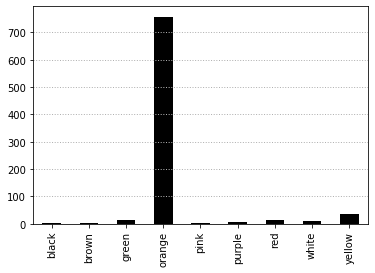

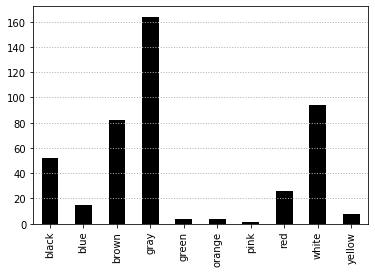

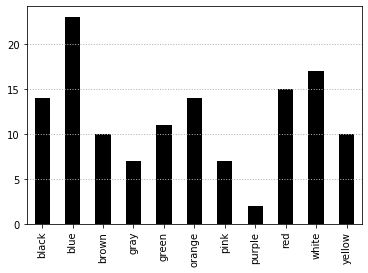

In [16]:
all_obj.loc[all_obj.object_name == 'carrot'].groupby('color').size().plot(kind='bar', cmap='gray')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
plt.xlabel("")
plt.show()

all_obj.loc[all_obj.object_name == 'stone'].groupby('color').size().plot(kind='bar', cmap='gray')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
plt.xlabel("")
plt.show()

all_obj.loc[all_obj.object_name == 'fish'].groupby('color').size().plot(kind='bar', cmap='gray')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
plt.xlabel("")
plt.show()

### number of CDOs, CNOs, CBOs in the test set

In [17]:
print('CDO: all: {n}, typical: {t}, atypical: {a}'.format(n=len(predict_cdo), t=len(canonical_cdos), a=len(noncanonical_cdos)))
print('CBO:', len(predict_cbo))
print('CNO:', len(predict_cno))

CDO: all: 1192, typical: 887, atypical: 305
CBO: 933
CNO: 1755


### differences between Early Fusion and Late Fusion

34 entries
2405028.jpg
purple bush


<ipython-input-2-d06840368345>:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out_series = pd.Series()


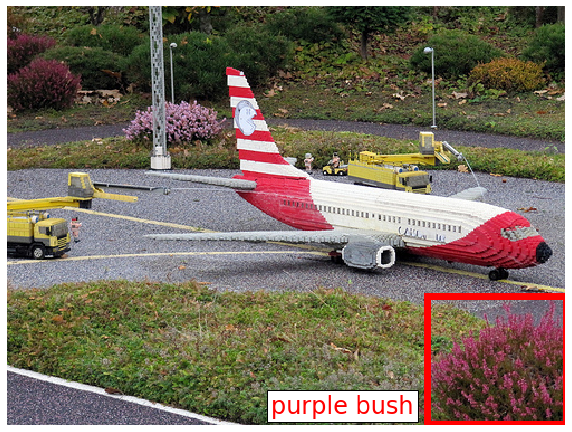

\caption{purple bush}
\begin{tabular}{ll}
pixelwise   &   brown \\
bottomup    &  purple \\
topdown     &   green \\
latefusion  &   green \\
earlyfusion &  purple \\
\end{tabular}



pixelwise       brown
bottomup       purple
topdown         green
latefusion      green
earlyfusion    purple
dtype: object

In [18]:
# sample images

df = predict_cdo.copy()
df['typical'] = df.apply(lambda x:x.color == color_diagnostic_objects[x.object_name], axis=1)

class_1 = 'earlyfusion_color'
class_2 = 'latefusion_color'

sample = df.loc[df['color']==df[class_1]]\
        .loc[df['color']!=df[class_2]]\
        .loc[df['typical']==False]
print(len(sample), 'entries')
#sample= sample.sample(10)

sample[['object_name','color',class_1, class_2]].head()

# display images
#sample.apply(lambda x:visualize.plot_vg_image(x,image_dir), axis=1)

# Figure 3 from ACL paper
bush = predict_cdo.loc[156556]
save_image(bush, image_dir, out_dir=None, save=False, print_pred=True, classifier_list=classifier_list, classifier_names=classifier_list, text='left')

In [19]:
# confusion matrices

confusion = predict_cdo.copy()
confusion = confusion[['object_id', 'image_id', 'object_name', 'color', 'earlyfusion_color', 'latefusion_color']]
confusion['typical'] = confusion.apply(lambda x: is_canonical(x['object_name'], x['color'], color_diagnostic_objects), axis=1)
confusion['earlyfusion_typical'] = confusion.apply(lambda x: is_canonical(x['object_name'], x['earlyfusion_color'], color_diagnostic_objects), axis=1)
confusion['latefusion_typical'] = confusion.apply(lambda x: is_canonical(x['object_name'], x['latefusion_color'], color_diagnostic_objects), axis=1)

confusion.head()

,object_id,image_id,object_name,color,earlyfusion_color,latefusion_color,typical,earlyfusion_typical,latefusion_typical
2097.0,1026220,202,sky,gray,blue,blue,False,True,True
2313.0,1537646,232,blinds,green,green,green,False,False,False
2631.0,1634833,266,leaves,green,green,green,True,True,True
6272.0,4299653,679,cloud,white,white,white,True,True,True
6452.0,1029259,704,tree,green,green,green,True,True,True


[[ 33 272]
 [ 53 834]]


[Text(0, 0.5, 'atypical'), Text(0, 1.5, 'typical')]

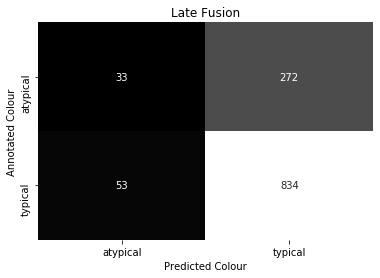

In [20]:
# confusion matrix for late fusion model

conf_m = confusion_matrix(confusion['typical'], confusion['latefusion_typical'])# / len(confusion)
print(np.round(conf_m, decimals=3))

ax= plt.subplot()
sns.heatmap(conf_m, annot=True, ax = ax, cmap='gray', fmt='g', cbar=False)
# labels, title and ticks
ax.set_xlabel('Predicted Colour')
ax.set_ylabel('Annotated Colour')
ax.set_title('Late Fusion')
ax.xaxis.set_ticklabels(['atypical', 'typical'])
ax.yaxis.set_ticklabels(['atypical', 'typical'])

# Table 2 from ACL paper

[[ 69 236]
 [ 53 834]]


[Text(0, 0.5, 'atypical'), Text(0, 1.5, 'typical')]

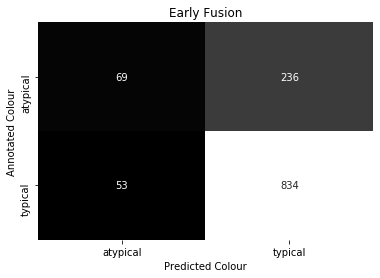

In [21]:
# confusion matrix for early fusion model


conf_m = confusion_matrix(confusion['typical'], confusion['earlyfusion_typical'])# / len(confusion)
print(np.round(conf_m, decimals=3))

ax= plt.subplot()
sns.heatmap(conf_m, annot=True, ax = ax, cmap='gray', fmt='g', cbar=False)
# labels, title and ticks
ax.set_xlabel('Predicted Colour')
ax.set_ylabel('Annotated Colour') 
ax.set_title('Early Fusion') 
ax.xaxis.set_ticklabels(['atypical', 'typical'])
ax.yaxis.set_ticklabels(['atypical', 'typical'])

# Table 2 from ACL paper

### sample image from VG

bb_h               229
bb_w               200
bb_x               109
bb_y                 0
color            green
image_id       2405333
object_id       332940
object_name       tree
Name: 153699, dtype: object

2405333.jpg
green tree


<ipython-input-2-d06840368345>:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out_series = pd.Series()


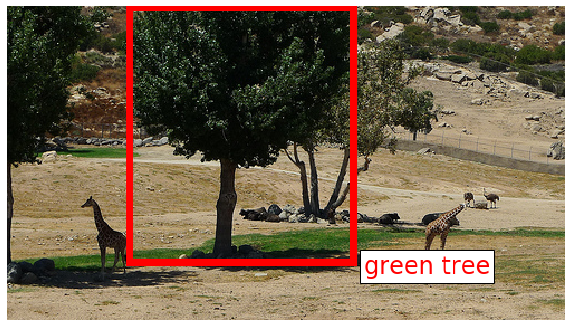

Series([], dtype: float64)

In [22]:
tree = all_obj.loc[all_obj.object_id == 332940].iloc[0]
display(tree)
save_image(tree, image_dir, out_dir=None, save=False, print_pred=False)
# save_image(tree, image_dir, out_dir='/home/simeon/Schreibtisch/', filename='sample.png')

# Figure 1 from ACL paper

### number of entries in each split

In [23]:
# Object Counts in Train, Dev, Test Splits

td_feats = np.load(data_dir + 'feature_arrays/object_types_resampled.npz', allow_pickle=True)

print('train objects:', len(td_feats['train_y']))
print('dev objects:', len(td_feats['dev_y']))
print('test objects:', len(td_feats['test_y']))

train objects: 110000
dev objects: 17523
test objects: 9328
